# Panorama Image Stitching
In this assignment, you will generate a stitched panorama image from multiple input images.



In [13]:
# Load required Libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os

## Read in the images

Note that there will be multiple image sets to try in this assignment. For full marks, you will need to report the results of your solution on each of the sets of images

In [14]:
# read images
path = '/Users/basabdattachaudhury/Downloads/Panoramaimages'
def load_images(set_name):
    input_path = path+ set_name
    filenames = [input_path+ filename for filename in os.listdir(input_path)]
    filenames = sorted(filenames)
    raw_images = [cv2.imread(filename) for filename in filenames]
    count = len(raw_images)
    return raw_images, count

## Reorder the images
As this assignment will require the merge of multiple images, we need to do some alignment of the images. THe idea is to reset the order of the images, and to make the centre image the "source" image, and to then extend the panorama to both sides. \

As this is not the key learning from this assignment, the code is provided, no modifications are required

In [15]:
# reset the order of the images to make the center one is the source image, and extend to both sides

def get_processed_images(raw_images):
    images = []
    count = len(raw_images)
    new_idx = (count - 1) // 2
    k = -1
    for i in range(count):
        new_idx = new_idx + k * i
        images.append(raw_images[new_idx])
        k *= -1

    # Let's initialize the source image
    img_src = images[0]
    return images, img_src

In [16]:
#Plotting the images

def plot_images(*imgs, figsize=(30,20), hide_ticks=False):
    '''Display one or multiple images.'''
    f = plt.figure(figsize=figsize)
    width = np.ceil(np.sqrt(len(imgs)))
    height = np.ceil(len(imgs) / width)
    for i, img in enumerate(imgs, 1):
        ax = f.add_subplot(height, width, i)
        if hide_ticks:
            ax.axis('off')
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Perform panorama stitching

In this section, implement the panorama image stitching. Note that there are multiple approaches that will work to achieve this, and you can find multiple examples online. In this assignment, we will work through one possible implementation. 

Note that in this example, the goal is to merge multiple images (many demos online only merge two images). Also, for this example, we will consider horizontal merges only. It is relatively straight forward to extend this implementation to consider vertical panorama stitching too.

Note: with this implementation, the quality varies with the number of input images (merging 2 images is ok, but for more than 2, the perspective isn't very good). So try varying the number of images used in the merge

In [21]:
#Performing the panorama stitching of the image


def stitch_images(images,img_src):
    for i in range(1, len(images)):
        img_dst = images[i]
    # making sure that the merge is from left to right
        if i % 2 == 0:
            img_src, img_dst = img_dst, img_src
    
        orb = cv2.ORB_create()
        # detects keypoints and computes the descriptors for "source" and "destination" images (hint: use ORB features)
        kp_left, des_left = orb.detectAndCompute(img_src, None)
        kp_right, des_right = orb.detectAndCompute(img_dst, None)
        keypoints_drawn_left = cv2.drawKeypoints(img_src, kp_left, None, color=(0, 0, 255))
        keypoints_drawn_right = cv2.drawKeypoints(img_dst, kp_right, None, color=(0, 0, 255))
       
        # create a brute foce matching function, and calculate the matches
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(des_left,des_right)

    
        # sort the matches by distance
        matches_drawn = cv2.drawMatches(img_src, kp_left, img_dst, kp_right, matches, None, matchColor=(0,0,255), flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
        limit = 50
        best = sorted(matches, key = lambda x:x.distance)[:limit]
    
        # Keep only the top 50 matches
        best_matches_drawn = cv2.drawMatches(img_src, kp_left, img_dst, kp_right, best, None, matchColor=(0,0,255), flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
        

    
        # Get the keypoints from the matches
        src_pts = np.zeros((len(matches), 2), dtype=np.float32).reshape(-1, 1, 2)
        dst_pts = np.zeros((len(matches), 2), dtype=np.float32).reshape(-1, 1, 2)
        for i, match in enumerate(matches):
            src_pts[i, :] = kp_left[match.queryIdx].pt
            dst_pts[i, :] = kp_right[match.trainIdx].pt
    
    # Compute the homography matrix using RANSAC
            M, _ = cv2.findHomography(np.float32(dst_pts), np.float32(src_pts),cv2.RANSAC)
    # show the keypoint matches (hint: use the opencv drawMatches function)
            image_matches=cv2.drawMatches(img_src,kp_left,img_dst,kp_right,best, None)
    
    # show matched points image

        plt.imshow(image_matches)
        plt.show()

    #get the height and width of the original images
        h1, w1, p1 = img_src.shape
        h2, w2, p2 = img_dst.shape
        h = np.maximum(h1, h2)
        w = np.maximum(w1, w2)

        move_dis = int(np.maximum(dst_pts[0][0][0], src_pts[0][0][0]))
    

        dim=(w1 + w2 - move_dis, h)
        warped = cv2.warpPerspective(img_dst, M, dim)
   
      # combine the source image to the transformed image
        img_transform = warped.copy()
    # combine the two images
        img_transform[0:img_src.shape[0],0:img_src.shape[1]] = img_src
    #crop
        r_crop = move_dis + w
        img_transform = img_transform[:, :r_crop]
    
   
    # use img_transform as the source image for the next iteration of the loop
        img_src = img_transform
    
        return img_src
    
    

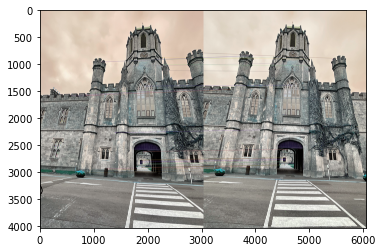

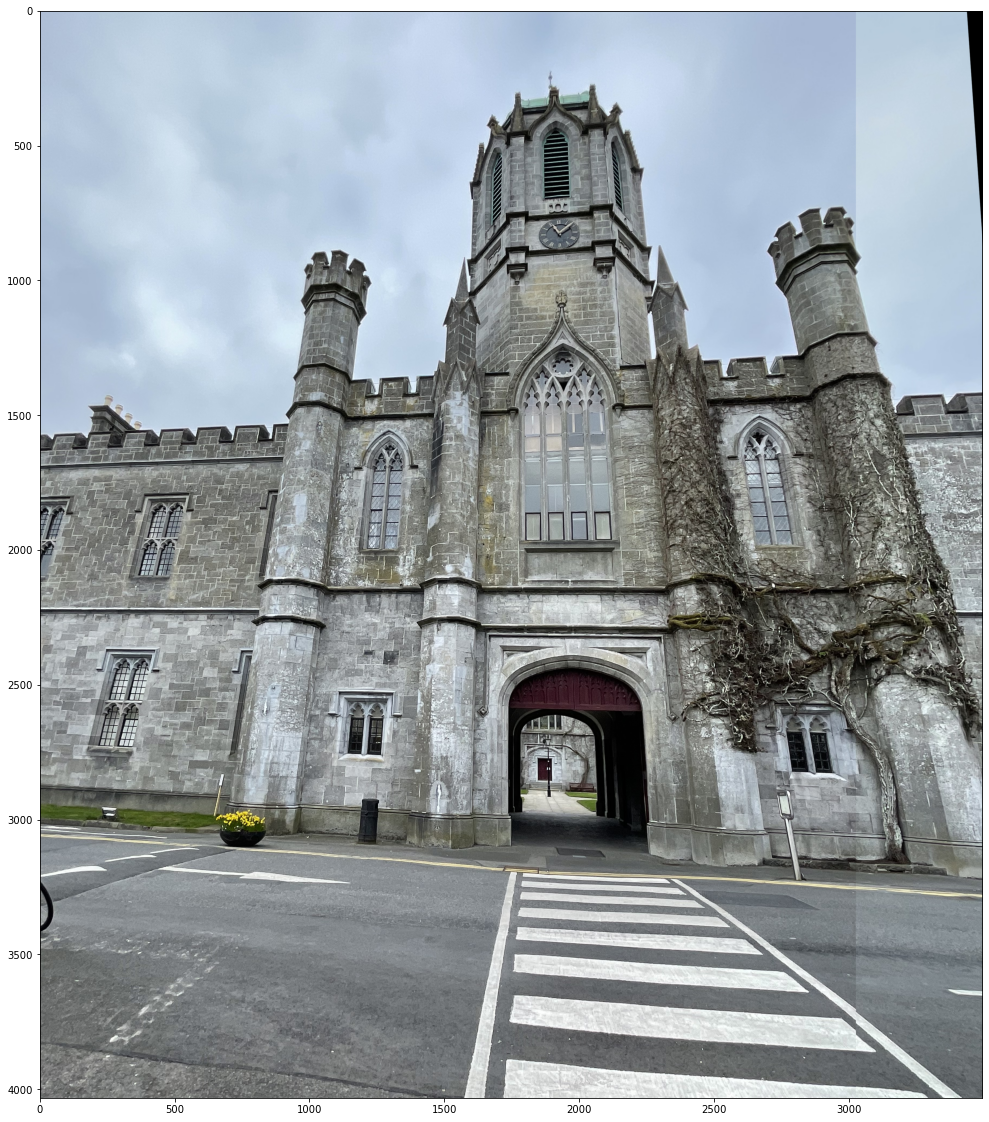

(<matplotlib.image.AxesImage at 0x7fbcf8d8d820>, None)

In [36]:
# Display final panorama

raw_images,count=load_images('/set_1/')
images, img_src=get_processed_images(raw_images)
img_src=stitch_images(images,img_src)
fig = plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(img_src,cv2.COLOR_BGR2RGB)), plt.show()


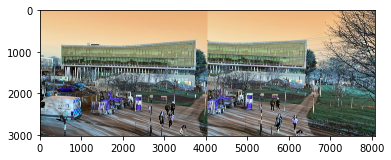

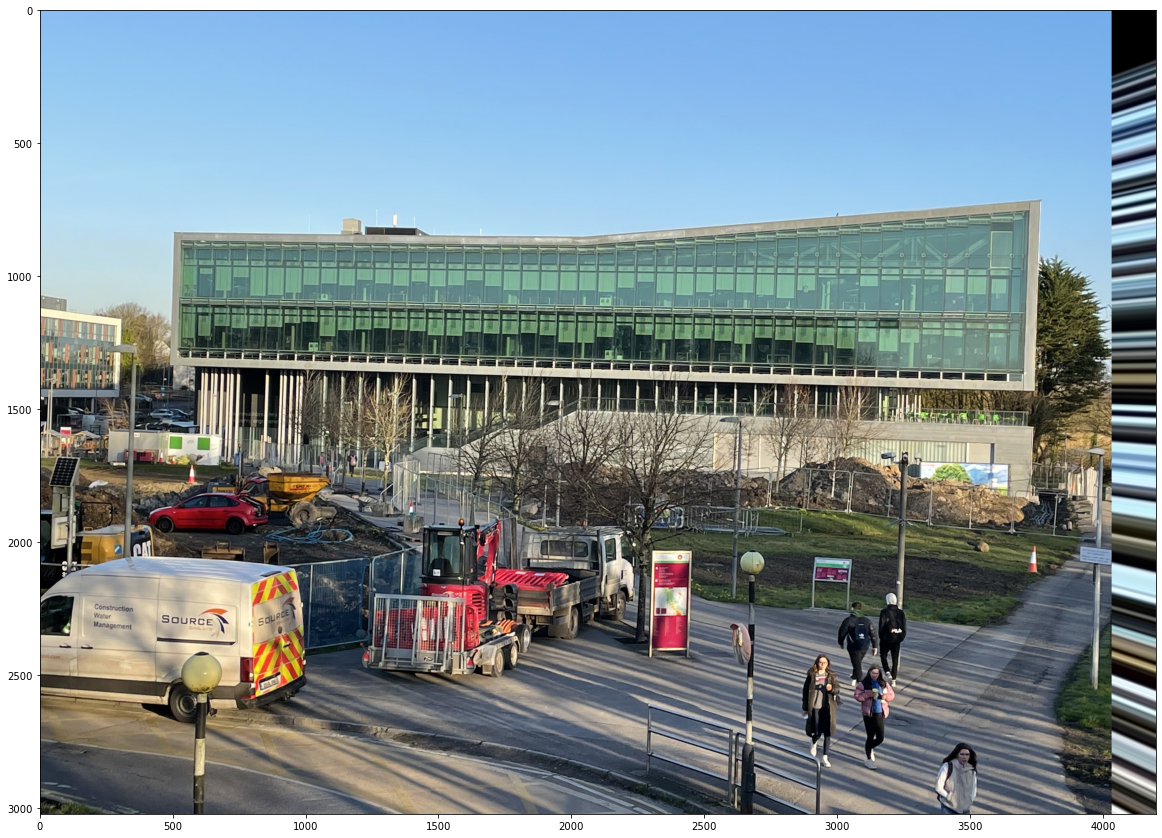

(<matplotlib.image.AxesImage at 0x7fbd20106460>, None)

In [37]:
raw_images,count=load_images('/set_2/')
images, img_src=get_processed_images(raw_images)
img_src=stitch_images(images,img_src)
fig = plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(img_src,cv2.COLOR_BGR2RGB)), plt.show()

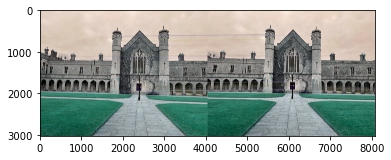

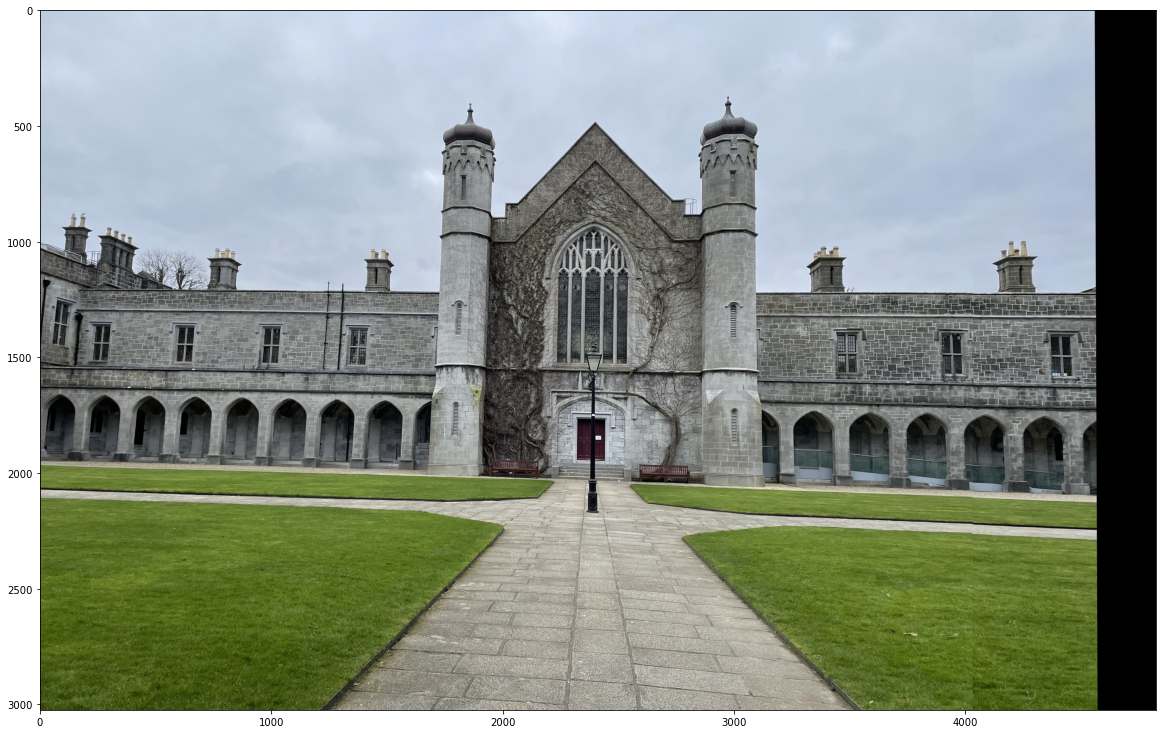

(<matplotlib.image.AxesImage at 0x7fbcf8e01f10>, None)

In [38]:
raw_images,count=load_images('/set_3/')
images, img_src=get_processed_images(raw_images)
img_src=stitch_images(images,img_src)
fig = plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(img_src,cv2.COLOR_BGR2RGB)), plt.show()

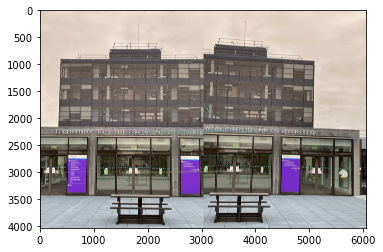

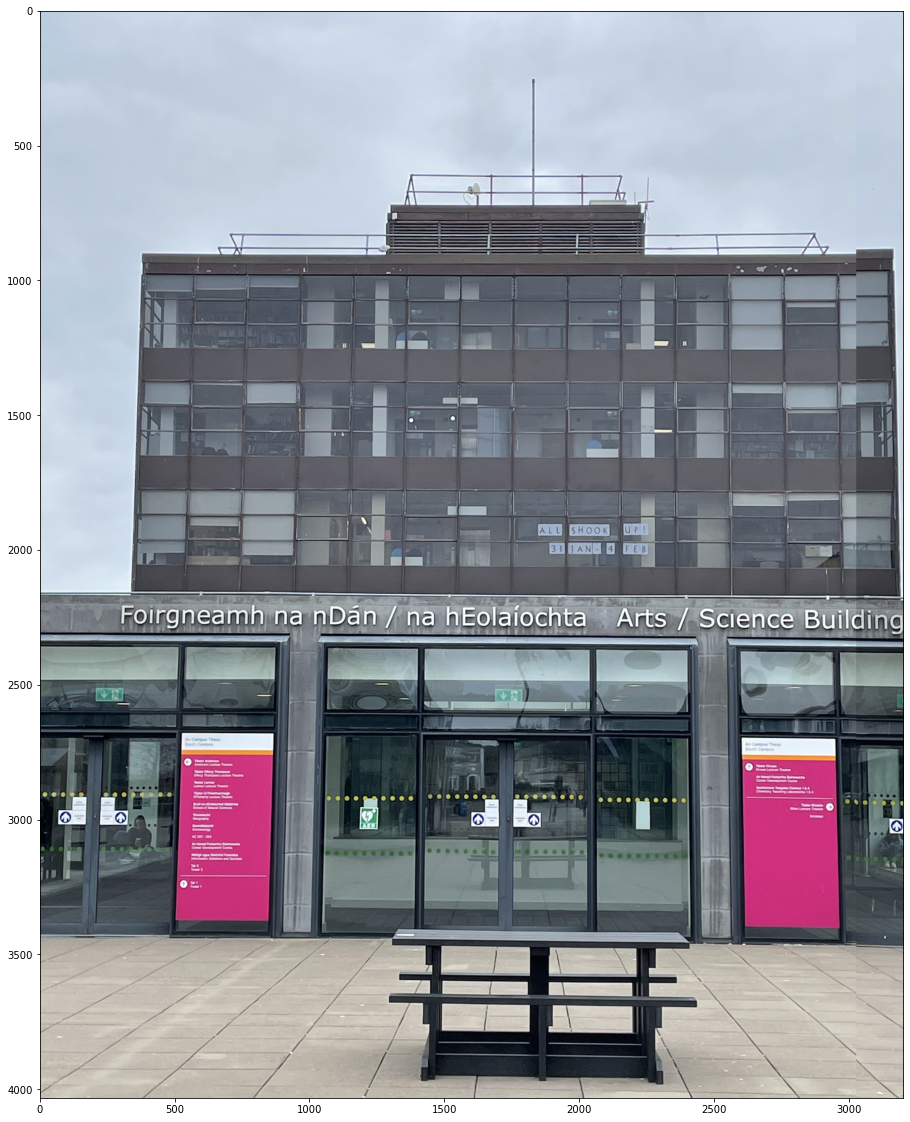

(<matplotlib.image.AxesImage at 0x7fbcf2ac94f0>, None)

In [35]:
raw_images,count=load_images('/set_4/')
images, img_src=get_processed_images(raw_images)
img_src=stitch_images(images,img_src)
fig = plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(img_src,cv2.COLOR_BGR2RGB)), plt.show()

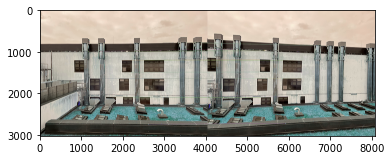

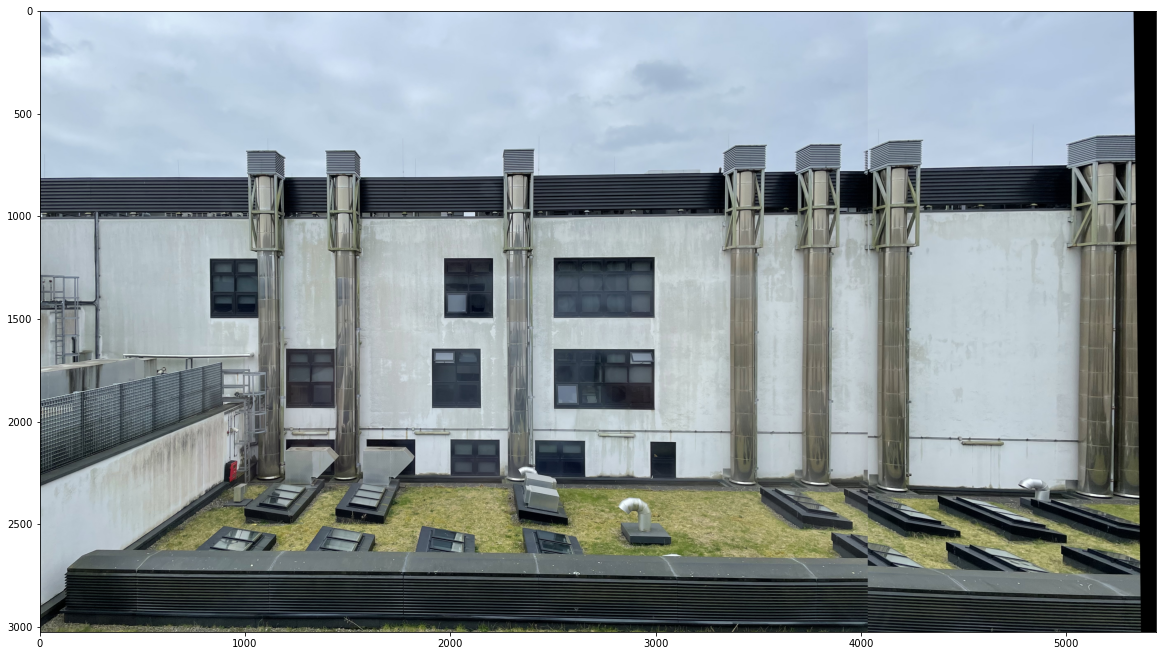

(<matplotlib.image.AxesImage at 0x7fbd10ac72e0>, None)

In [34]:
raw_images,count=load_images('/set_5/')
images, img_src=get_processed_images(raw_images)
img_src=stitch_images(images,img_src)

fig = plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(img_src,cv2.COLOR_BGR2RGB)), plt.show()

## Summary of findings
At this stage, you should have tried your implementation on all of the image sets provided.\
You should have noticed by now that:
- One of the sets does not give a good result (and a lot of artifacts with the "out of the box" solution
- In some cases, even when there is a relatively good stitch, the final panorama perspective isn't very good
- A black boarder is visible in the image
- There are some mismatches in image brightness
- there are sharp transitions between merged images

For all of the points above, suggest 
- A reason for the issue
- A potential fix for the issue


# Here are the reason and potential fix for the problems that we see in the above panorama stitching:

1. Poor stitch quality for some images:

Reason: The images may not have enough overlap or may have inconsistent lighting, perspective, or features.


Fix: Manually adjust the alignment or brightness of the images, or try using different stitching algorithms or parameters to improve the match quality.


2. Poor perspective in final panorama:

Reason: The perspective may be distorted due to the stitching algorithm, focal length, or camera placement.


Fix: Try using a different stitching algorithm or adjusting the focal length or camera placement to improve the perspective.


3. Black border in final panorama:

Reason: The stitching algorithm may not have fully aligned the images, leaving a black border around the edges.


Fix: Manually adjust the alignment or cropping of the images, or try using a different stitching algorithm or parameters to improve the alignment.

4. Mismatches in image brightness:

Reason: The images may have inconsistent brightness or exposure settings.


Fix: Adjust the brightness or exposure of the images before stitching, or use a stitching algorithm that can handle brightness differences between images.


5. Sharp transitions between merged images:

Reason: The images may have sharp edges or other high-contrast features that are difficult for the stitching algorithm to merge smoothly.


Fix: Manually adjust the blending or feathering of the images, or use a stitching algorithm that can handle high-contrast features more smoothly.

